## SQLAlchemyおよびRaziを用いた化合物データベースの利用のチュートリアル2  
続けて類似構造検索をする方法を学ぶ

In [1]:
from collections import namedtuple
import csv
import psycopg2
import sys
from mytables import Compound

from razi.rdkit_postgresql.types import Mol, Bfp
from razi.rdkit_postgresql.functions import atompairbv_fp, torsionbv_fp, morganbv_fp, mol_amw, dice_sml, tanimoto_sml

from rdkit import Chem, rdBase
from rdkit.Chem import Draw

from sqlalchemy import create_engine, desc, Column, Index, Integer, String
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker


print(sys.version_info)
print(f'RDKit version: {rdBase.rdkitVersion}')

sys.version_info(major=3, minor=6, micro=0, releaselevel='final', serial=0)
RDKit version: 2017.03.1


### 1. テーブルの定義と構築

[Razi-tutorial-japanese](Razi-tutorial-japanese.ipynb)にて構築をしたテーブル`compounds`を最後に削除した場合は  
再び以下のセルを実行しテーブル`compounds`の定義及び構築をしてほしい。  
[Razi-tutorial-japanese](Razi-tutorial-japanese.ipynb)でデータを更新したり削除したりした場合、データが変化しているのでこれから行う類似構造検索の結果も変わってくる。  
テーブルを削除しなかった人でそのように結果が変わってくるのが望ましくない人は一度テーブルを削除し再度構築して欲しい。

In [2]:
!python mytables.py

ここで[Razi-tutorial-japanese](Razi-tutorial-japanese.ipynb)にて省略した部分について説明をしていく。[mytables.py](http://0.0.0.0:8888/edit/tutorial/mytables.py)のコードも随時確認しながら進めてもらえるとよい。

#### 1.1 テーブルのカラム

```
    atompair = Column(Bfp)
    torsion = Column(Bfp)
    morgan = Column(Bfp)
```

テーブル`compounds`は`atompair`, `torsion`, `morgan`という名前のカラムを持つように定義されている。  
それぞれ`Column`クラスのコンストラクタの引数に`Bfp`を与えることでBinary Fingerprintであると定義している。  

#### 1.2 fingerprintのインデックス

fingerprintにもインデックスを作成することが多いが今回は約25000個とデータベースにしては少なめのデータなので省略している。  
`mol`同様`gist`用いることができる。

#### 1.1.3 コンストラクタ

```
    def __init__(self, name, structure):
        self.name = name
        if isinstance(structure, Chem.Mol):
            self.structure = Chem.MolToSmiles(structure)
        elif isinstance(structure, str):
            self.structure = structure
        self.atompair = atompairbv_fp(self.structure)
        self.torsion = torsionbv_fp(self.structure)
        self.morgan = morganbv_fp(self.structure, 2)
```

モジュール`razi.rdkit_postgresql.functions`の`atompairbv_fp`, `torsionbv_fp`, `morganbv_fp`を用いて  
与えられた化学構造に対するfingerprintを計算している。  
`morganbv_fp`はfingerprintの特性上さらに整数の引数が必要なので今回は2にした(ECFP2の2を表している)。

### 2. データベースに接続する

In [3]:
engine = create_engine('postgresql://postgres@db:5432/postgres')
Base = declarative_base(bind=engine)
Session = sessionmaker(bind=engine)
session = Session()

### 3. データの登録

テーブルを削除せずすでにデータが登録されている人はこの章は飛ばしてよい。

データを抽出する関数の宣言をする。

In [4]:
Record = namedtuple('Record', 'chembl_id, smiles, inchi, inchi_key')


def read_chembldb(filepath, limit):
    with open(filepath, 'rt') as inputfile:
            reader = csv.reader(inputfile, delimiter='\t', skipinitialspace=True)
            #headerを飛ばす
            next(reader)

            for count, record in enumerate(map(Record._make, reader), start=1):
                smiles = record.smiles

                #特定の三重結合をRDKitで読めるように変換する。
                smiles = smiles.replace('=N#N','=[N+]=[N-]')
                smiles = smiles.replace('N#N=','[N-]=[N+]=')            

                #invalidなsmilesは読み込まない
                if not Chem.MolFromSmiles(smiles):
                    continue

                yield count, record.chembl_id, smiles
                if count == limit:
                    break

前回と同様に引数`limit=25000`で登録を行う。マシンパワーによっては登録に時間がかかるかもしれない。

In [5]:
for count, chembl_id, smiles in read_chembldb('chembl_23_chemreps.txt', 25000):
    compound = Compound(chembl_id, smiles)
    session.add(compound)
session.commit()

In [6]:
session.query(Compound).count()

25000

私のパソコンだと1分ほどで登録が終了した。

### 4. 類似構造検索

今回は以下の化学構造と類似の化学構造を検索してみる。

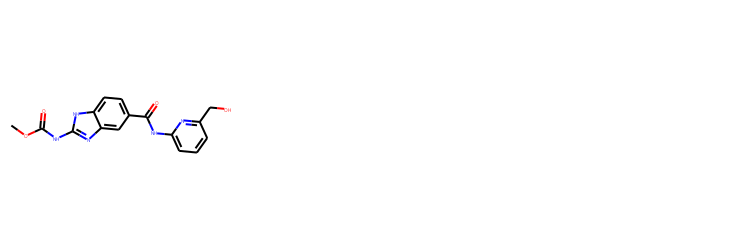

In [7]:
smiles = 'COC(=O)Nc1nc2cc(C(=O)Nc3cccc(CO)n3)ccc2[nH]1'
mol = Chem.MolFromSmiles(smiles)
Draw.MolsToGridImage([mol], subImgSize=(250, 250))

#### 4.1 Tanimoto係数に基づく類似構造検索

まず上記のSMILESに対するfingerprintを計算する。今回は`atompairbv_fp`関数を用いてみよう。

In [8]:
fp = atompairbv_fp(smiles)

この計算したfingerpirntを用いてTanimoto係数を求め基準値(デフォルトは0.5)以上の係数の類似度の化学構造のみを検索する。

In [9]:
compounds = session.query(Compound)
compounds = compounds.filter(Compound.atompair.tanimoto_sml(fp))
compounds.count()

11

11個の化合物が検索ヒットした。そのうちの6個を取り出して画像を表示してみよう。

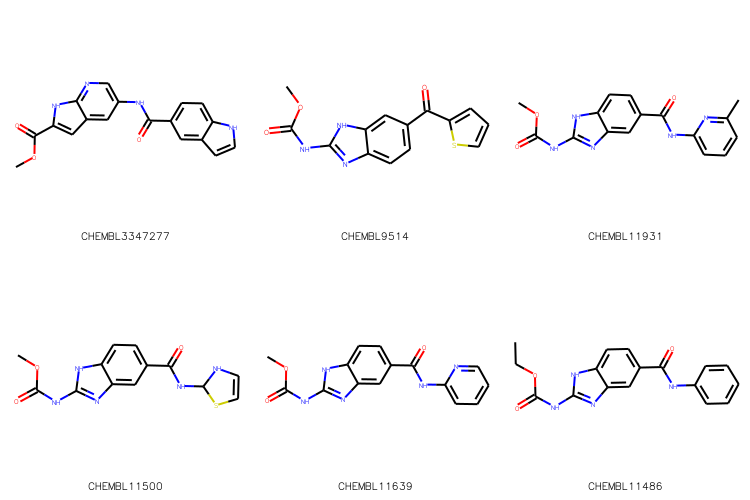

In [10]:
compounds = compounds[:6]
Draw.MolsToGridImage([compound.structure for compound in compounds], legends=[compound.name for compound in compounds], 
                                         subImgSize=(250, 250))

類似度の高い化学構造が得られている。

#### 4.2 Dice係数に基づく類似構造検索

Tanimoto係数ではなくDice係数を用いたい場合`dice_sml`メソッドを用いる。こちらも基準値のデフォルトは0.5である。  
以下に、fingerprintとして`morganbv_fp`関数、類似性の指標として`dice_sml`メソッドを用いた例を示す。

In [11]:
fp = morganbv_fp(smiles, 2)

In [12]:
compounds = session.query(Compound)
compounds = compounds.filter(Compound.morgan.dice_sml(fp))
compounds.count()

28

28個の化合物が検索ヒットした。そのうちの6個を取り出して画像を表示してみよう。

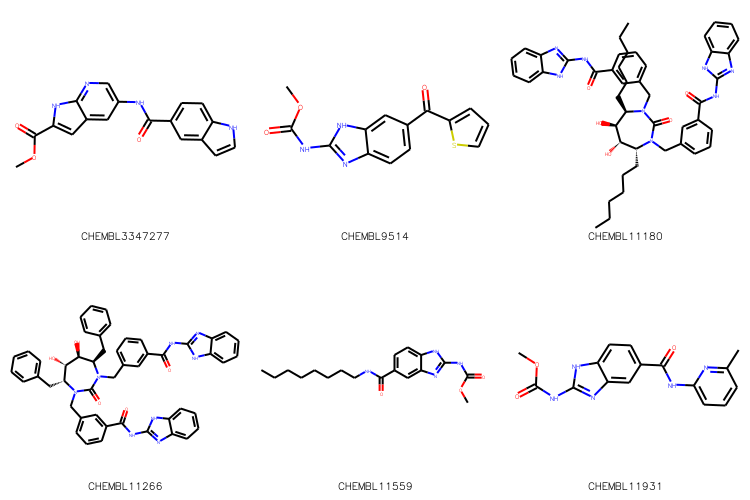

In [13]:
compounds = compounds[:6]
Draw.MolsToGridImage([compound.structure for compound in compounds], legends=[compound.name for compound in compounds], 
                                         subImgSize=(250, 250))

CHEMBL11180などは部分構造として同じような構造を持つが(少なくとも私としては)似ているとはいい難い。  
したがって検索ヒットした28個が前から類似度が高い順番に並んでいないので類似度あまり高くないものの画像を表示している可能性がある。

そこで`order_by`メソッドを使って類似度の値で降順に並べてみよう。  
類似度の値を求めるには`razi.rdkit_postgresql.functions`モジュールの`tanimoto_sml`, `dice_sml`関数を用いる。  

少しややこしいが
- 類似性の値で**絞り込む時**はテーブルカラムの`tanimoto_sml`, `dice_sml`メソッド
- 類似性の値を計算して**得たい時**は`razi.rdkit_postgresql.functions`モジュールの`tanimoto_sml`, `dice_sml`関数
を用いる。  

今回は`query`メソッドの引数の中が複雑になるので一度先に新たなカラムを宣言してみる。

In [14]:
fp = morganbv_fp(smiles, 2)
dice_similarity = dice_sml(Compound.morgan, fp).label('similarity')
subset = session.query(Compound, dice_similarity)
print(subset.count())
subset = subset.filter(Compound.morgan.dice_sml(fp)).order_by(desc('similarity'))
subset.count()

25000


28

In [15]:
for record in subset:
    compound, similarity = record[0], record[1]
    print(f'name: {compound.name},\tsimilarity: {similarity}')

name: CHEMBL11931,	similarity: 0.872340425531915
name: CHEMBL11639,	similarity: 0.829787234042553
name: CHEMBL11655,	similarity: 0.790697674418605
name: CHEMBL24334,	similarity: 0.771084337349398
name: CHEMBL11670,	similarity: 0.769230769230769
name: CHEMBL11691,	similarity: 0.769230769230769
name: CHEMBL11993,	similarity: 0.765957446808511
name: CHEMBL11378,	similarity: 0.760869565217391
name: CHEMBL11864,	similarity: 0.758620689655172
name: CHEMBL11882,	similarity: 0.752688172043011
name: CHEMBL11559,	similarity: 0.752688172043011
name: CHEMBL11486,	similarity: 0.747252747252747
name: CHEMBL11865,	similarity: 0.739130434782609
name: CHEMBL11725,	similarity: 0.73469387755102
name: CHEMBL11500,	similarity: 0.715789473684211
name: CHEMBL11705,	similarity: 0.7
name: CHEMBL11698,	similarity: 0.695652173913043
name: CHEMBL9514,	similarity: 0.695652173913043
name: CHEMBL685,	similarity: 0.674418604651163
name: CHEMBL12325,	similarity: 0.666666666666667
name: CHEMBL24184,	similarity: 0.55462

降順に並べることができた。先程の`CHEMBL11180`は`dice_similarity=0.5263`と28個の中ではあまり類似性が高くなかったのがわかる。

最後に上位6個を取り出して画像を表示してみよう。まずは類似性を比較した化学構造を再度表示する。

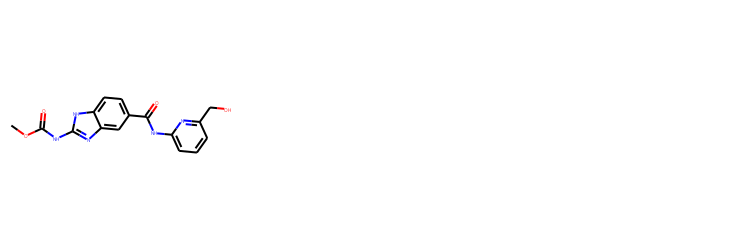

In [16]:
smiles = 'COC(=O)Nc1nc2cc(C(=O)Nc3cccc(CO)n3)ccc2[nH]1'
mol = Chem.MolFromSmiles(smiles)
Draw.MolsToGridImage([mol], subImgSize=(250, 250))

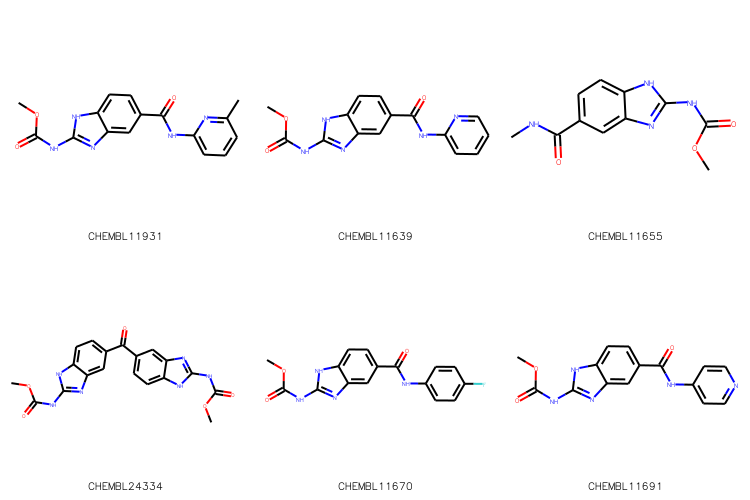

In [17]:
compounds = [record[0] for record in subset[:6]]
Draw.MolsToGridImage([compound.structure for compound in compounds], legends=[compound.name for compound in compounds], 
                                         subImgSize=(250, 250))

類似度の高い化学構造が得られている。

#### 4.3 類似度の指標の基準値の変更

現在のTanimoto係数、Dice係数の基準値は`session.scalar`メソッドを使って確認することができる。

In [18]:
session.scalar('show rdkit.tanimoto_threshold')

'0.5'

In [19]:
session.scalar('show rdkit.dice_threshold')

'0.5'

この値を変更するメソッドなどは現在存在していないのでSQL文を直接書いて実行できる`execute`メソッドを使って変更する。

In [20]:
session.execute('set rdkit.tanimoto_threshold=0.7')

In [21]:
session.scalar('show rdkit.tanimoto_threshold')

'0.7'

Tanimoto係数の基準値が0.7に変更された。4.2で行った類似構造検索をもう一度行ってみる。

In [22]:
fp = atompairbv_fp(smiles)

In [23]:
compounds = session.query(Compound)
compounds = compounds.filter(Compound.atompair.tanimoto_sml(fp))
compounds.count()

2

基準値を大きくしたので検索ヒットした化合物数が11個から2個に減っている。

### 5. sessionの終了

最後はsessionをcloseしておこう。sessionをつながっているとテーブルを削除したりできなくなる。

In [24]:
session.close()

### 6. テーブルの削除

最後にtutorialで作成したテーブルを削除してみる。`Compound`クラスで作成したテーブルの削除には`Compound.__table__.drop`メソッドを用いる。

In [25]:
Compound.__table__.drop()